# Test of the dose units

This notebook is simply a check that the units are correct for the dose calculation.

## Code setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ROOT
import os

Welcome to JupyROOT 6.14/08


In [2]:
%matplotlib notebook

# plt.rcParams['figure.figsize'] = [8, 5]
# plt.rcParams['figure.dpi'] = 100
# 
# #colorCycle = plt.rcParams['axes.prop_cycle']
# plt.rcParams['figure.max_open_warning'] = 100

In [3]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [4]:
#Setup MiniScatter
import sys
MiniScatter_path="../build/."
sys.path.append(MiniScatter_path)
#import CLEARview

import miniScatterDriver
import miniScatterScanner
import miniScatterPlots

/usr/lib64/python3.6/site-packages/ROOT.py:461: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )


## Physics / simulation setup

In [5]:
SI_e = 1.60217662e-19 #[C]

In [6]:
### Basic simulation parameters ###

QUIET   = False #Reduce the ammount of output
TRYLOAD = True  #Try to load already existing data instead of recomputing?

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS"
baseSimSetup["PHYS"]  = "QGSP_BERT"
baseSimSetup["N"]     = 10000

baseSimSetup["ENERGY"] = 215.0 #[MeV]
baseSimSetup["ZOFFSET"]           = 0.0

baseSimSetup["WORLDSIZE"] = 1000.0 #Make the world wider, to contain the shower

baseSimSetup["DIST"] = 3000.0 #Detector distance from target center [mm]

baseSimSetup["QUICKMODE"] = False  #Include slow plots
baseSimSetup["MINIROOT"]  = True   #Skip TTRees in the .root files
baseSimSetup["EDEP_DZ"]   = 1.0    #Z-binning for energy deposition plots

baseSimSetup["OUTFOLDER"]=os.path.join(os.getcwd(),"DoseDeposition_unitsCheck")
baseSimSetup["THICK"] = 3000
baseSimSetup["MAT"] = "G4_WATER"

## Simulation / Electrons

In [7]:
baseSimSetup_e = baseSimSetup.copy()
baseSimSetup_e["BEAM"] = "e-"
baseSimSetup_e["OUTNAME"]="electrons"

baseSimSetup_e["N"]=10000

(twiss_e, numPart_e, objects_e) = miniScatterDriver.getData_tryLoad(baseSimSetup_e, tryload=True,\
    getObjects=["targetEdep","target_edep_dens","target_edep_rdens","metadata"])

Did not find any pre-computed data at '/home/kyrsjo/cernbox/MiniScatter/examples/DoseDeposition_unitsCheck/electrons.root', computing now.
Running command line: './MiniScatter -t 3000 -m G4_WATER -d 3000.0 -w 1000.0 -p QGSP_BERT -n 10000 -e 215.0 -b e- -z 0.0 -f electrons -o /home/kyrsjo/cernbox/MiniScatter/examples/DoseDeposition_unitsCheck -r --edepDZ 1.0'
RunFolder = '/home/kyrsjo/cernbox/MiniScatter/build'
Done!
No particles found for det=tracker_cutoff
No particles found for det=target_cutoff


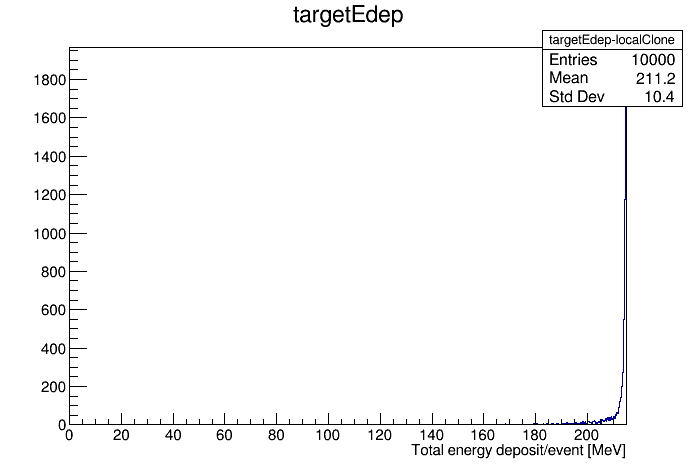

In [8]:
c1 = ROOT.TCanvas()
objects_e['targetEdep'].Draw()
c1.Draw()

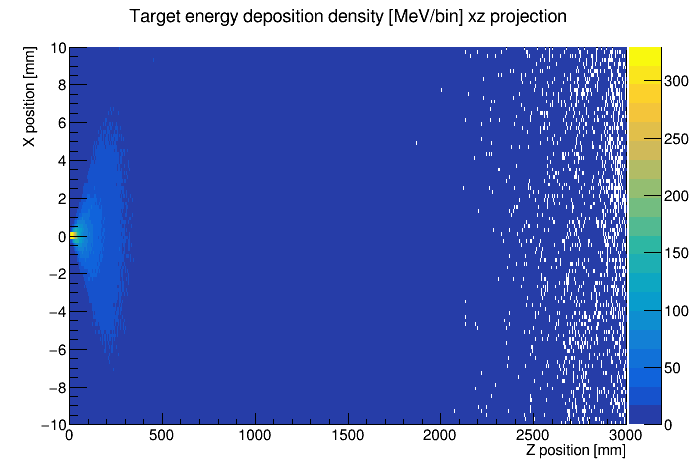

In [9]:
c2 = ROOT.TCanvas()
objects_e['target_edep_dens_xz'] = objects_e['target_edep_dens'].Project3D('xz')
#objects_e['target_edep_dens_xz'].SetContour(100, np.linspace(0,0.3,100))
objects_e['target_edep_dens_xz'].SetStats(False)
objects_e['target_edep_dens_xz'].Draw('colz')
c2.Draw()

In [10]:
#Compute the various scalings

nElec = (1e-9/SI_e) # 1 nC of electrons
scaleFactor_nElec = nElec/baseSimSetup_e["N"] # physical electrons / simulated electrons
scaleFactor_energyUnit = 1.6021766e-13 #J/MeV
scaleFactor_binVolume = objects_e['target_edep_dens'].GetXaxis().GetBinWidth(1)*\
                        objects_e['target_edep_dens'].GetYaxis().GetBinWidth(1)*\
                        objects_e['target_edep_dens'].GetZaxis().GetBinWidth(1)*1e-3 #[cm^3]
scaleFactor_density = objects_e['metadata'][2]*1e-3 #[kg/cm^3]
scaleFactor = scaleFactor_nElec * scaleFactor_energyUnit / (scaleFactor_binVolume * scaleFactor_density)

print("nElec                  =", nElec, "[e-]")
print("nEvents                =", baseSimSetup_e["N"], "[events]")
print("scaleFactor_nElec      =", scaleFactor_nElec, "[physical electrons/simulated electrons]")
print("scaleFactor_energyUnit =", scaleFactor_energyUnit, "[J/MeV]")
print("binWidths (X/Y/Z)      =", objects_e['target_edep_dens'].GetXaxis().GetBinWidth(1), \
                                  objects_e['target_edep_dens'].GetYaxis().GetBinWidth(1), \
                                  objects_e['target_edep_dens'].GetZaxis().GetBinWidth(1), \
                                  "[mm]")
print("scaleFactor_binVolume  =", scaleFactor_binVolume, "[cm^3]")
print("scaleFactor_density    =", scaleFactor_density, "[kg/cm^3]")
print("scaleFactor            =", scaleFactor, "[Gy/(MeV/bin)]")

nElec                  = 6241509128.999773 [e-]
nEvents                = 10000 [events]
scaleFactor_nElec      = 624150.9128999773 [physical electrons/simulated electrons]
scaleFactor_energyUnit = 1.6021766e-13 [J/MeV]
binWidths (X/Y/Z)      = 0.2 0.2 1.0 [mm]
scaleFactor_binVolume  = 4.000000000000001e-05 [cm^3]
scaleFactor_density    = 0.001 [kg/cm^3]
scaleFactor            = 2.4999999687924532 [Gy/(MeV/bin)]


In [11]:
#Units check, virtual calorimetry

#This is assuming that everything gets absorbed IN the block
print("Expected total energy     =", nElec*scaleFactor_energyUnit*baseSimSetup_e["ENERGY"], "[J]")

#Should be slightly less, since some may escape
targetEdepIntegral = 0.0
for bin in range(1, objects_e['targetEdep'].GetNbinsX()+1):
    targetEdepIntegral += objects_e['targetEdep'].GetBinContent(bin) * \
                          objects_e['targetEdep'].GetBinCenter(bin)
targetEdepIntegral *= scaleFactor_energyUnit*scaleFactor_nElec
print("Sum over edep/event       =", targetEdepIntegral, "[J]")

print("Sum over deposits (x/y/z) =", objects_e['target_edep_dens'].Integral(0,objects_e['target_edep_dens'].GetNbinsX()+1,\
                                                                            0,objects_e['target_edep_dens'].GetNbinsY()+1,\
                                                                            0,objects_e['target_edep_dens'].GetNbinsZ()+1)\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, \
                                   "[J] (including overflow bins)")
print("Sum over deposits (x/y/z) =", objects_e['target_edep_dens'].Integral()\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, "[J] (excluding overflow bins)")
print("Sum over deposits (r)     =", objects_e['target_edep_rdens'].Integral(0,objects_e['target_edep_rdens'].GetNbinsX()+1,\
                                                                           0,objects_e['target_edep_rdens'].GetNbinsY()+1)\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, "[J] (including overflow bins)")
print("Sum over deposits (r)     =", objects_e['target_edep_rdens'].Integral()\
                                   * scaleFactor_energyUnit*scaleFactor_nElec, "[J] (excluding overflow bins)")

Expected total energy     = 0.21499999731615108 [J]
Sum over edep/event       = 0.20325453671276986 [J]
Sum over deposits (x/y/z) = 0.21119025179906134 [J] (including overflow bins)
Sum over deposits (x/y/z) = 0.054527751604011875 [J] (excluding overflow bins)
Sum over deposits (r)     = 0.2111902517990593 [J] (including overflow bins)
Sum over deposits (r)     = 0.08225682661269551 [J] (excluding overflow bins)


We see that when including the overflow bins (i.e. whatever is outside of $x,y \in \pm$` RootFileWriter::phasespacehist_posLim = 10.0*mm`, $0<r<$` RootFileWriter::phasespacehist_posLim = 10.0*mm`), we account for the whole expected energy deposition by summing over the histograms, less a little bit that probably was backscattered and escaped somehow.
However when only taking whatever is inside these limits, we get a smaller number, and the two ways are roughly consistent. Some loss of precission was expected when integrating the energy deposition histogram so this is OK.

Next step is to check the units using the scaled plots which are given in terms of dose \[Gy = J/kg\].
This is defined as
$$
D = \Delta E/M
$$
where $D$ is the dose deposited in some object, $\Delta E$ the enery deposited in the same object, and $M$ the mass of the object.

For a distribution $D(\vec r)$ this implies that
$$
D(\vec r) = \frac{\Delta E(\vec r)}{\rho \; \mathrm{d}V} \, ,
$$
where $\rho$ is the mass density, so that
$$
\Delta E = \int_{\forall V} D(\vec r) \; \rho \; \mathrm{d}V \, .
$$
For a volume of constant density, we can pull the mass density outside.

In [12]:
objects_e['target_edep_dens_scaled'] = ROOT.TH3D(objects_e['target_edep_dens'])
objects_e['target_edep_dens_scaled'].Scale(scaleFactor)
objects_e['target_edep_dens_scaled'].SetTitle("Target dose distribution [Gy]")

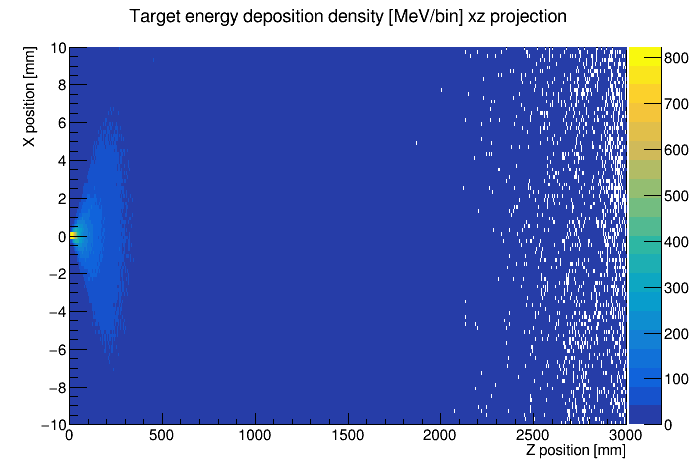

In [13]:
c3 = ROOT.TCanvas()
objects_e['target_edep_dens_scaled_xz'] = objects_e['target_edep_dens_scaled'].Project3D('xz')
#print(objects_e['target_edep_dens_scaled'].GetTitle())
#print(objects_e['target_edep_dens_scaled_xz'].GetTitle())
#objects_e['target_edep_dens_xz'].SetContour(100, np.linspace(0,0.3,100))
objects_e['target_edep_dens_scaled_xz'].SetStats(False)
objects_e['target_edep_dens_scaled_xz'].Draw('colz')
c3.Draw()

In [14]:
#Remember to scale the integral binvolume from mm3 to cm3!
print("Integrated dose (x/y/z) = ", objects_e['target_edep_dens_scaled'].Integral('width')*1e-3 * \
                                    scaleFactor_density, \
                                    "[J]")

Integrated dose (x/y/z) =  0.05452775160399721 [J]


That looks correct!

Note that the point at the entrance is effectively a singularity.

## Radial distribution

For a azimuthally symmetric problem like the one we're treating here, the "radial" r/z distribution is more interesting. However here we need to take care that the volume element changes with r.

This is done in the `miniScatterPlots` routines.

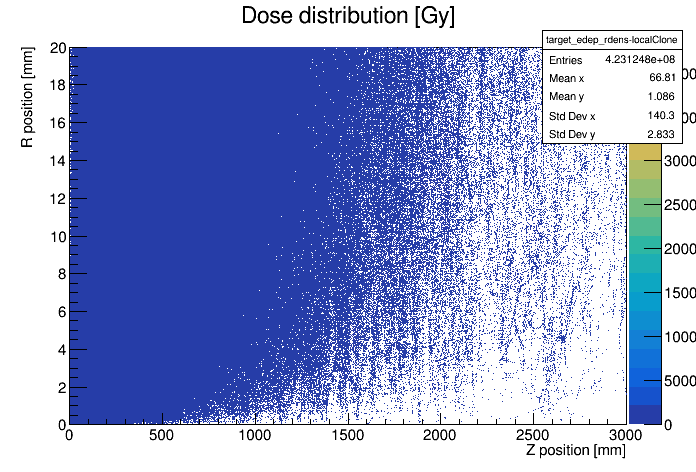

In [15]:
rzScaled_e = miniScatterPlots.plotRZgray(objects_e,\
                                         baseSimSetup_e["N"], 1e-9/SI_e)
c4 = ROOT.TCanvas()
#rzScaled_e.SetContour(100, np.linspace(0,100,100))
#rzScaled_e.GetXaxis().SetRangeUser(0,400)
#rzScaled_e.GetYaxis().SetRangeUser(0,10)
rzScaled_e.Draw('colz')
c4.Draw()

In [16]:
#Let's integrate that back again to see that we can find back the total deposited energy.

rzScaled_e_integral = 0.0;
for rIdx in range(1,rzScaled_e.GetNbinsY()):
    dA = np.pi*(rzScaled_e.GetYaxis().GetBinUpEdge(rIdx)**2 - rzScaled_e.GetYaxis().GetBinLowEdge(rIdx)**2) #[mm^2]
    for zIdx in range(1,rzScaled_e.GetNbinsX()):
        dZ = rzScaled_e.GetXaxis().GetBinUpEdge(zIdx)-rzScaled_e.GetXaxis().GetBinLowEdge(zIdx) #[mm]
        dV = dA*dZ*1e-3 #[cm^3]
        rzScaled_e_integral += rzScaled_e.GetBinContent(zIdx,rIdx)*scaleFactor_density*dV
print("Integrated dose (r) = ", rzScaled_e_integral, "[J]")

Integrated dose (r) =  0.08220229993149412 [J]


That's the same as above! It looks like it all matches up.

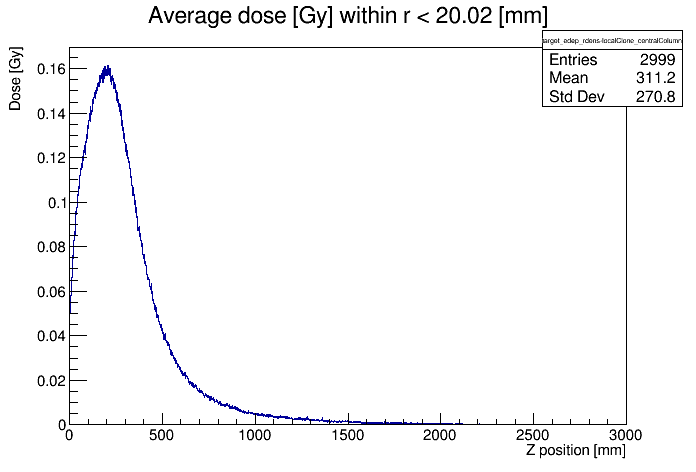

In [17]:
# Let's try the plotZgray routine

rMax = rzScaled_e.GetYaxis().GetBinUpEdge(rzScaled_e.GetNbinsY())
zGray = miniScatterPlots.plotZgray(rzScaled_e, rMax)

c5 = ROOT.TCanvas()
zGray.Draw('colz')
c5.Draw()

In [18]:
#Can we get back the energy?

#Remember mm -> cm
print("Integrated dose = ", zGray.Integral("width")*(np.pi*rMax**2)*1e-3 * scaleFactor_density, "[J]")

Integrated dose =  0.08209233399309787 [J]


Looks same-ish!